CS224U Final Project: Analysis of Gender Roles and Bias in Literary Portrayal of Characters
===

In [109]:
__authors__ = "Stephanie Wang, Megha Srivastava, Sarai Gould"
__version__="CS224u, Stanford, Spring 2016 term"

In [110]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
from collections import Counter, OrderedDict
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import chi2, SelectPercentile
from pandas import DataFrame
import scipy.stats
import utils

### Overview
##### Features
The input to these functions is a list of features to train on. Ideally this is a list of dictionaries which can then be dictvectorized into a feature matrix. 
Current features:
 - Unigrams
 - Dependencies
 - Genres
 - Date of Publication
 - Sentence Length


In [111]:
import re
import codecs 

#labels are: Male Char, Female Auth: MCFA; Female Char, Female Auth: FCFA; Male Char, Male Auth: MCMA;
#Female Char, Male Auth: FCMA; Male Char, Female Char, Female Auth: MCFCFA; Male Char, Female Char Male Auth: MCFCMA
def train_file_reader(src_filename):
    num_gender = {"FA": 0, "MA": 0}
    curr_author_gender = "FA"
    curr_genre = "Default_Genre"
    curr_pub = "0000"
    all_lines_file = codecs.open(src_filename, 'r', 'utf8')
    iterable_file = iter(all_lines_file)
    for line in iterable_file:
        if "#####" in line:   
            #line represents a new book in the dataset, indicating a change in author gender, pub year, and genre
            if "GENDER:MALE" in line:
                curr_author_gender = "MA"
                num_gender["MA"] = num_gender["MA"] + 1
            else:
                curr_author_gender = "FA"
                num_gender["FA"] = num_gender["FA"] + 1
            pub_year_pattern = re.compile('#PUB:(\d+)#') #extracts publication year
            pub_matches = pub_year_pattern.findall(line)
            if pub_matches:
                curr_pub = pub_matches[0]
            genre_pattern = re.compile('#GENRE:(.+)#PUB') #extracts genre
            genre_matches = genre_pattern.findall(line)
            if genre_matches:
                curr_genre = genre_matches[0]
        if line.startswith("SENTENCE: "): #sentence to label
            label = ""
            if "00MALE00" in line:
                label += "MC"
            if "00FEMALE00" in line:
                label += "FC"
            if label == "":
                continue
            label += curr_author_gender
            unigrams_list = []
            for word in line.split(" "):
                if (not ("00MALE00" in word) and not ("00FEMALE00" in word) and not (word.startswith("SENTENCE:"))):
                    unigrams_list.append(word) #gets all unigrams except those obviously indicating gender
            unigrams_length = len(unigrams_list) #gets the length of sentence
            dependency_list = []
            line = next(iterable_file)
            if line.startswith("DEPENDENCY: "): #dependencies corresponding to above sentence
                for dep in line.split(" "):
                    if (dep != "DEPENDENCY:"):
                        dependency_list.append(dep)
            if not dependency_list:
                continue
            yield(unigrams_list, unigrams_length, dependency_list, curr_pub, curr_genre, label) #returns a generator
        
def train_reader():
    #hard-code file HERE
    return train_file_reader("all_files_lines_deps.txt.v3")    

def features_phi(unigrams, length, dependencies, pub, genre):
    features_list = []
    features_list.extend(unigrams)
    features_list.extend(dependencies)
    features_list.append(length)
    #publication date feature is currently divided into buckets by century. Change this code to 
    #use buckets of decades, centuries, etc. 
    if pub.startswith("18"):
        features_list.append("1800")
    elif pub.startswith("19"):
        features_list.append("1900")
    elif pub.startswith("17"):
        features_list.append("1700")
    elif pub.startswith("16"):
        features_list.append("1600")
    else:
        features_list.append("0000")
    #appends genre feature
    features_list.append(genre)
    #turns feature list into a dictionary
    return Counter(features_list)

## Create Comparison Charts of Genders and Genres

In [112]:
def data_reader(src_filename):
    curr_author_gender = "FA"
    curr_genre = "Default_Genre"
    curr_pub = "0000"
    all_lines_file = codecs.open(src_filename, 'r', 'utf8')
    iterable_file = iter(all_lines_file)
    for line in iterable_file:
        if "#####" in line:   
            #line represents a new book in the dataset, indicating a change in author gender, pub year, and genre
            if "GENDER:MALE" in line:
                curr_author_gender = "MA"
            else:
                curr_author_gender = "FA"
            pub_year_pattern = re.compile('#PUB:(\d+)#') #extracts publication year
            pub_matches = pub_year_pattern.findall(line)
            if pub_matches:
                curr_pub = pub_matches[0]
            genre_pattern = re.compile('#GENRE:(.+)#PUB') #extracts genre
            genre_matches = genre_pattern.findall(line)
            if genre_matches:
                curr_genre = genre_matches[0]
            yield(curr_author_gender, curr_pub, curr_genre)

In [6]:
def  build_gender_chart(num_gender, gendre_genre, gender_pub):
    
    for author_gen, pub, genre in data_reader("all_files_lines_deps.txt.v3"):
        num_gender[author_gen] = num_gender[author_gen] + 1
        gender_pub[author_gen].append(int(pub))
        gender_genre[author_gen].append(genre)       


In [7]:
num_gender = {"MA": 0, "FA": 0}
gender_genre = {"MA": [], "FA": []}
gender_pub = {"MA": [], "FA": []}

build_gender_chart(num_gender, gender_genre, gender_pub)

### Plot Count of Female and Male Authors

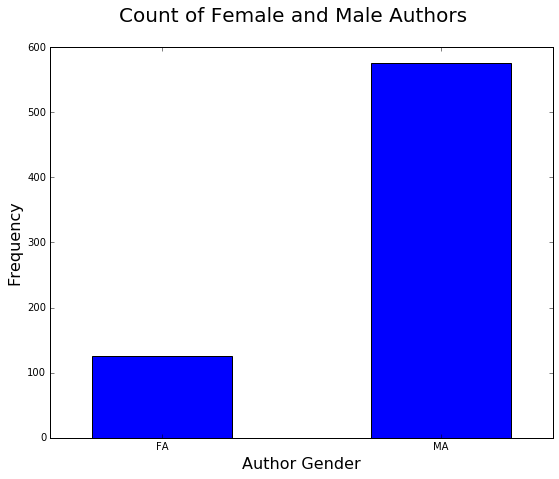

In [8]:
male_genre = Counter(gender_genre["MA"])
female_genre = Counter(gender_genre["FA"])
male_pub = Counter(gender_pub["MA"])
female_pub = Counter(gender_pub["FA"])

def plot_author_count (num_gender):
    #plot number of authors in dataset, separated by gender
    fig1, ax1 = plt.subplots(figsize=(9, 7))
    fig1.suptitle('Count of Female and Male Authors', fontsize=20)
    ax1.bar(range(len(num_gender)), num_gender.values(), align='center', width=0.5)
    plt.xticks(range(len(num_gender)), num_gender.keys())
    plt.xlabel('Author Gender', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.show()

plot_author_count(num_gender)

### Plot Count of Publication Date for Male and Female Authors

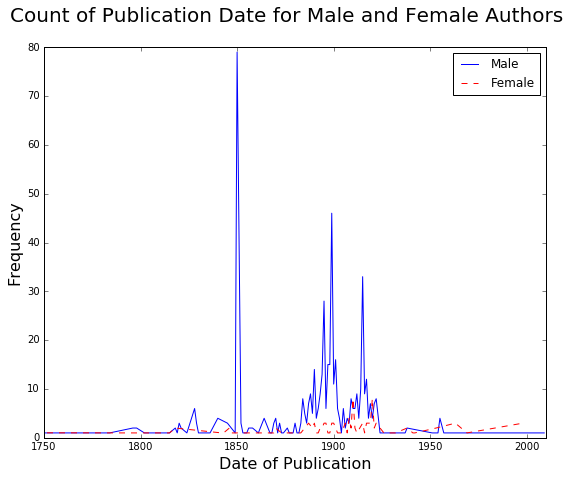

In [10]:
def plot_pub_date_count(male_pub, female_pub):
    #Sort the dates and plot the number of publications that year, separated by male and female
    male_pub_dict = OrderedDict(sorted(male_pub.items(), key=lambda t:t[0]))
    female_pub_dict = OrderedDict(sorted(female_pub.items(), key=lambda t:t[0]))
    fig2, ax2 = plt.subplots(figsize=(9, 7))
    fig2.suptitle('Count of Publication Date for Male and Female Authors', fontsize=20)
    ax2.plot(male_pub_dict.keys(), male_pub_dict.values(), 
             color='blue', linestyle='-', label='Male', linewidth=1)
    ax2.plot(female_pub_dict.keys(), female_pub_dict.values(), 
             color = 'red', linestyle='--', label="Female", linewidth=1)
    plt.xlabel('Date of Publication', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend()
    pylab.xlim(1750, 2010)
    plt.show()

plot_pub_date_count(male_pub, female_pub)

### Plot Genre Frequencies

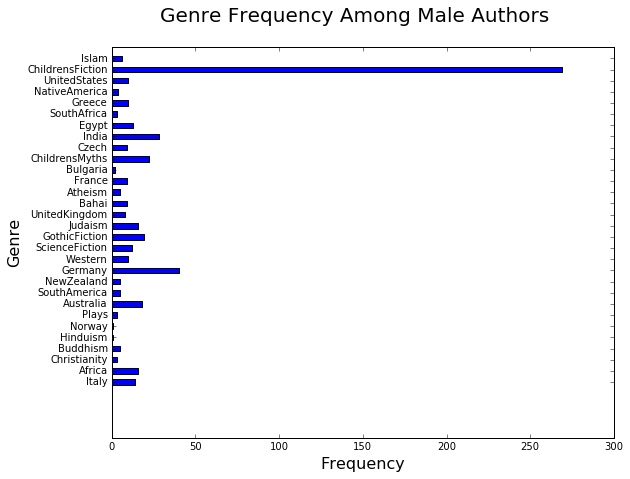

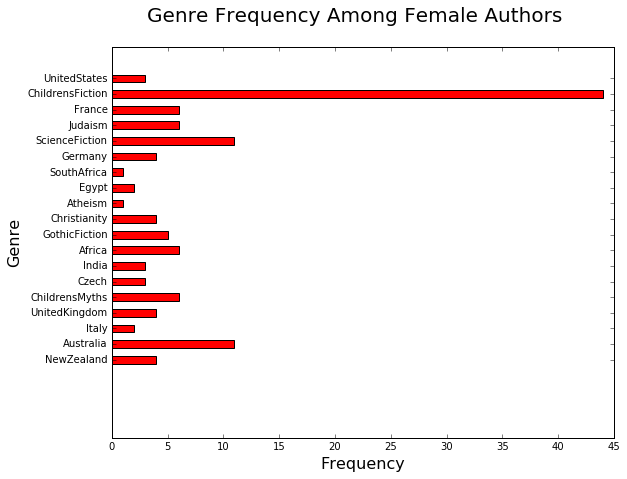

In [43]:
def plot_genre_freq(male_genre, female_genre):
    #Show the count of texts published in a certain genre for male and female authors
    fig3, ax3 = plt.subplots(figsize=(9, 7))
    fig3.suptitle('Genre Frequency Among Male Authors', fontsize=20)
    ax3.barh(range(len(male_genre)), male_genre.values(), align='center', 
             height=0.5, tick_label=male_genre.keys())
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Genre', fontsize=16)
    plt.show()

    fig4, ax4 = plt.subplots(figsize=(9, 7))
    fig4.suptitle('Genre Frequency Among Female Authors', fontsize=20)
    ax4.barh(range(len(female_genre)), female_genre.values(), align='center', 
             color='red', height=0.5, tick_label=female_genre.keys())
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Genre', fontsize=16)
    plt.show()
    
plot_genre_freq(male_genre, female_genre)

## Build Dataset for experiments

In [88]:
def build_dataset(reader, phi, vectorizer=None):
    """
    Parameters
    ----------
    reader : iterator
        This is the dataset that we are featurizing
        
    vectorizer : sklearn.feature_extraction.DictVectorizer
        If this is None, then a new `DictVectorizer` is created and
        used to turn the list of dicts created by `phi` into a 
        feature matrix. This happens when we are training.

        If this is not None, then it's assumed to be a `DictVectorizer` 
        and used to transform the list of dicts. This happens in 
        assessment, when we take in new instances and need to 
        featurize them as we did in training.
    Returns
    -------
    dict
        A dict with keys 'X' (the feature matrix), 'y' (the list of labels), 
        'vectorizer' (the 'DictVectorizer'), and 'raw_examples'(for error analysis).
    """
    labels = []
    feat_dicts = []
    for unigrams, length, deps, pub, genre, label in reader():
        if genre != "ScienceFiction":
            continue
        labels.append(label)
        feat_dicts.append(phi(unigrams, length, deps, pub, genre))
    feat_matrix = None
    #In training, we want a new vectorizer:
    if vectorizer == None:
        vectorizer = DictVectorizer(sparse=True)
        feat_matrix = vectorizer.fit_transform(feat_dicts)
        feat_names = vectorizer.get_feature_names()
    #In assessment, we featurize using the existing vectorizer:
    else:
        feat_matrix = vectorizer.fit_transform(feat_dicts)
    
    return {'X': feat_matrix,
            'y': labels,
            'featureNames': feat_names,
            'vectorizer': vectorizer}

## Fit the classifier on our feature matrix and labels

In [89]:
def fit_maxent_classifier(X, y):    
    """Wrapper for `sklearn.linear.model.LogisticRegression`. This is also 
    called a Maximum Entropy (MaxEnt) Classifier, which is more fitting 
    for the multiclass case.
    
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.
    
    Returns
    -------
    sklearn.linear.model.LogisticRegression
        A trained `LogisticRegression` instance.
    
    """
    mod = LogisticRegression(fit_intercept=True)
    mod.fit(X, y)
    return mod

## Run experiment to train and test our model

In [106]:
def experiment(
            train_reader=train_reader,
            assess_reader=None,
            train_size=0.7,
            phi = features_phi,
            train_func=fit_maxent_classifier,
            score_func=utils.safe_macro_f1,
            select_feat=False,
            verbose=True):
    """
    Parameters
    ==========
    train_reader : Iterator for training data.
    
    assess_reader : Iterator for assessment data.
    
    train_size : float
        If 'assess_reader' is None, then this is percentage of 
        'train_reader' devoted to training. Else this is ignored.
    train_func : model wrapper
        Any function taking in a feature matrix and label list
        and returns a fitted model with a 'predict' function
        that operates on feature matrices.
    score_metric : Scoring function, default is weighted average F1
    verbose : bool
        Whether to print out model assessment to standard output.
    
    Prints
    ======
    Model accuracy and model precision/recall/F1 report.
    
    Returns
    =======
    Float
        Overall scoring metric determined by 'score_metric'.
    """
    # Train dataset:
    train = build_dataset(train_reader, phi, vectorizer=None)
    #Manage the assessment set-up:
    X_train = train['X']
    y_train = train['y']
    feature_names = train['featureNames']
    X_assess = None
    y_assess = None
    if assess_reader == None:
        #'train_test_split' is a sklearn function that splits arrays or matrices into random train and test subsets
        X_train, X_assess, y_train, y_assess = train_test_split(
                X_train, y_train, train_size=train_size)
    else:
        #Assessment dataset using the training vectorizer:
        assess = build_dataset(assess_reader, phi, vectorizer=None)
        X_assess, y_assess = assess['X'], assess['y']
    
    #Perform feature selection, selects the top percentage of features for classification
    if select_feat:
        selector = SelectPercentile(chi2, percentile=50)
        X_train = selector.fit_transform(X_train, y_train)
        X_assess = selector.transform(X_assess)
        feature_names = [feature_names[i] for i in selector.get_support(indices=True)]
        print (len(feature_names))
    #Train:
    mod = train_func(X_train, y_train)
    
    #Predictions:
    predictions = mod.predict(X_assess)
    print (mod.coef_.shape)
    print (X_assess.shape)
    print(X_train.shape)
    #Print features and feature weights
    coef = np.matrix(mod.coef_)
    df = DataFrame(coef.transpose(), index = feature_names)
    print('Feature names and their weights:')
    print (df.sort_values([1], ascending=[False]))
    #Report:
    if verbose:
        print('Accuracy: %0.03f' % accuracy_score(y_assess, predictions))
        print(classification_report(y_assess, predictions, digits=3))
    # Return the overall score:
    return score_func(y_assess, predictions) 
        

In [107]:
_ = experiment(select_feat=True)

67947
(6, 67947)
(3038, 67947)
(7086, 67947)
Feature names and their weights:
                                  0         1         2         3         4  \
Illia                     -0.370235  1.488751 -1.208702 -0.246705  0.014071   
3                          0.354518  1.260154 -0.045654 -0.137204 -0.022004   
Del                       -0.083509  1.194505 -0.382745 -0.019226 -0.036460   
Dance                     -0.082158  1.138539 -0.504244 -0.025554 -0.022364   
Mara                      -0.233423  1.127987 -0.784948 -0.160656  0.200561   
Molly                     -0.126078  1.032888 -0.432627 -0.084733  0.260573   
Grampa                    -0.444929  1.032060 -1.013988 -0.203256 -0.171266   
scared                    -0.156279  0.947418 -0.360688  0.291556 -0.068545   
dice                      -0.257930  0.885697 -0.826909 -0.155175  0.213008   
advmod_said_softly\n      -0.343126  0.879774 -0.457796 -0.065303 -0.087331   
Nothing                   -0.496497  0.872986 -0.3861

## Hyperparameter Search

In [ ]:
def fit_classifier_with_crossvalidation(X, y, basemod, cv, param_grid, scoring='accuracy'):
    #Find the best model within param_grid:
    crossvalidator = GridSearchCV(basemod, param_grid, cv=cv, scoring=scoring)
    crossvalidator.fit(X, y)
    print("Best params", crossvalidator.best_params_)
    print("Best score: %0.03f" % crossvalidator.best_score_)
    return crossvalidator.best_estimator_

In [ ]:
def fit_maxent_with_crossvalidation(X, y):
    basemod = LogisticRegression()
    cv = 5
    param_grid = {'fit_intercept': [True, False],
                 'C': [0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 0.9, 0.5],
                 'penalty': ['l1', 'l2']}
    return fit_classifier_with_crossvalidation(X, y, basemod, cv, param_grid)

In [ ]:
_ = experiment(
        train_func=fit_classifier_with_crossvalidation)